In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from desispec.interpolation import resample_flux

from collections import Counter

import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc('font', family='serif', size=16)

## Load the .fits files

In [2]:
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
specdir = 'galaxy_sim_catalog/spectra/'
expid = 4

gal_globpath = basedir + specdir + 'galaxies/*expid%03d*.fits' % expid
sn_globpath  = basedir + specdir + 'bright_atpeak/*expid%03d*.fits' % expid
# sn_globpath  = basedir + specdir + 'dim_atpeak/*expid%03d*.fits' % expid
# sn_globpath  = basedir + specdir + 'faint_atpeak/*expid%03d*.fits' % expid
# sn_globpath  = basedir + specdir + 'very_faint_atpeak/*expid%03d*.fits' % expid

# Galaxies without supernovae
gal_files = glob.glob(gal_globpath)
# Galaxies with supernovae
sn_host_files = glob.glob(sn_globpath)
# All the files
all_files = np.append(gal_files, sn_host_files)

print len(gal_files), "total galaxies"
print len(sn_host_files), "total sn hosts"

21000 total galaxies
18900 total sn hosts


## Read in the data to an astropy table

In [3]:
spec_table = Table(names=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                          'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'),
                 dtype=('S23', 'S4', 'S5', float, 
                        float, float, list, list, list))

for n, f in enumerate(all_files):
        
    # Read the fits file
    with fits.open(f, memmap=0) as hdul:

        specid  = os.path.basename(f)[8:31] # Spectra ID tag
        objtype = hdul[0].header['OBJTYPE'] # Object type (e.g. BGS)

        # Throw out non-galaxy types (sky/calib star)
        if objtype in ['SKY', 'FSTD']:
            continue
        else:
            has_sn  = hdul[0].header['HAS_SN'] # flag indicating SN or not
            Z    = hdul[0].header['REDSHIFT']  # redshift of the spectrum
            mag  = hdul[0].header['MAG']       # magnitude of host galaxy
            wave = hdul[1].data / (Z+1) # wavelength shifted to rest frame
            if not has_sn:
                flux = hdul[2].data * 1e-17 # gal fluxes aren't in units
                sn_epoch = np.nan           # placeholder for empty epoch
            else:
                flux = hdul[2].data         # flux values
                sn_epoch = hdul[0].header['SN_EPOCH'] # supernova epoch
            ivar = hdul[3].data # inverse variance (in the flux)
            # TODO: FIX IVAR UNIT SHIT
            
            # Create a new table row
            new_row = [specid, objtype, has_sn, sn_epoch, 
                       Z, mag, wave, flux, ivar]
            
            # And add it to the table
            spec_table.add_row(new_row)

## Eigenspectra Analysis

In [4]:
# Read in the eigenbasis
eigentable = np.genfromtxt(basedir + 'galaxy_sim_catalog/eigenspectra.txt')

global_wavelength_grid = eigentable[0]
eigenspectra = eigentable[1:]

In [5]:
# Resample spectra to a common wavelength grid
resample_fluxes = []
resample_ivars  = []
for spectra in spec_table:
    wave = spectra['WAVE']
    flux = spectra['FLUX']
    ivar = spectra['IVAR']
    spec_flux_resample, spec_ivar_resample = resample_flux(
                             global_wavelength_grid, wave, flux,
                             ivar=ivar, extrapolate=False
                            )
    resample_fluxes.append(spec_flux_resample)
    resample_ivars.append(spec_ivar_resample)
    
spec_table['RESAMPLED_FLUX'] = resample_fluxes
spec_table['RESAMPLED_IVAR'] = resample_ivars

In [6]:
# Loop through the spectra and calculate the residual
# flux after subtracting the eigenspectra fit
residual_fluxes = []
for spectra in spec_table:
    wave = spectra['WAVE']
    flux = spectra['RESAMPLED_FLUX']
    
    # Project/fit the basis to the spectrum
    basis_fit     = np.dot(np.linalg.pinv(eigenspectra.T), flux)
    bestfit_flux  = np.dot(basis_fit, eigenspectra)
    residual_flux = flux - bestfit_flux
    
    residual_fluxes.append(residual_flux)
    
spec_table['RESIDUAL_FLUX'] = residual_fluxes

In [7]:
# Get a table for all the galaxies with and without supernovae
galaxy_table  = spec_table[spec_table['HAS_SN'] == 'False']
sn_host_table = spec_table[spec_table['HAS_SN'] != 'False']

print len(spec_table)
print len(galaxy_table), len(sn_host_table)

37800
18900 18900


In [8]:
# Sort the table so we can read through it easier
spec_table.sort('ID')

In [9]:
sn_host_table.sort('ID')

## Plot some of the dataset

In [10]:
SN_fluxes = {}
nplots = 5

for specid in list(set(spec_table['ID']))[:nplots]:
    
    # Get the galaxy + SN host pair
    specs  = spec_table[spec_table['ID'] == specid]
    snhost = specs[specs['HAS_SN'] != 'False']
    gal    = specs[specs['HAS_SN'] == 'False']
    
    # Remove the galaxy from the supernova
    sn_flux = snhost['FLUX'] - gal['FLUX']
    sn_wave = snhost['WAVE']
    
    # Save the SN-only flux
    SN_fluxes[specid] = [sn_wave, sn_flux]

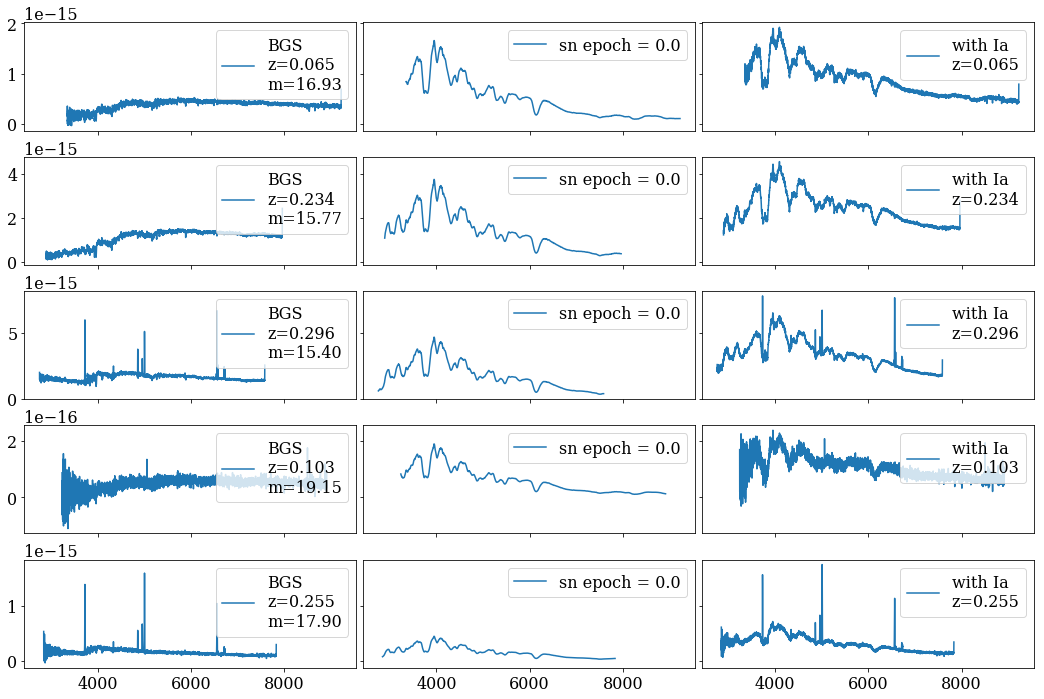

In [11]:
fig, axes = plt.subplots(nplots,3, figsize=(15, nplots*2), 
                         sharex=True, sharey='row')

for i, spec_id in enumerate(SN_fluxes):
    
    sn_host = sn_host_table[sn_host_table['ID'] == spec_id][0]
    galaxy = galaxy_table[galaxy_table['ID'] == spec_id][0]
    
    gal_label="%s\nz=%.3f\nm=%.2f" % (galaxy['OBJTYPE'], galaxy['REDSHIFT'], galaxy['MAG'])
    axes[i,0].plot(galaxy['WAVE'], galaxy['FLUX'], label=gal_label)
    axes[i,0].legend(loc='upper right')
    
    sn_label = "with %s\nz=%.3f" % (sn_host['HAS_SN'], sn_host['REDSHIFT'])
    axes[i,2].plot(sn_host['WAVE'], sn_host['FLUX'], label=sn_label)
    axes[i,2].legend(loc='upper right')
    
    sn_label="sn epoch = %.1f" % 0
    axes[i,1].plot(SN_fluxes[spec_id][0][0], 
                   SN_fluxes[spec_id][1][0], label=sn_label)
    axes[i,1].legend(loc='upper right')

fig.tight_layout(h_pad=0, w_pad=0)

# plt.savefig('../plots/galaxies_with_sn.png', format='png', 
#             dpi=300, bbox_inches='tight')

## Measure amplitudes of features

Table of feature boundaries in type Ia supernova spectra

from https://arxiv.org/pdf/1011.6227.pdf

| Feature | Dominating line | Lower region (centre A) | Upper region (centre A) | Rest wavelength (A) |
|---------||----------------|-------------------------||---------------|
|f1 | Ca II H&K           | 3450 - 3800 | 3800 - 4100 | 3945.12 |
|f2 | Si II $\lambda$4000 | 3800 - 3950 | 4000 - 4200 | 4129.73 |
|f3 | Mg II $\lambda$4300 | 3850 - 4250 | 4300 - 4700 | 4481.20 |
|f4 | Fe II $\lambda$4800 | 4300 - 4700 | 4950 - 5600 | 5083.42 |
|f5 | S II W              | 5050 - 5300 | 5500 - 5750 | 5536.24 |
|f6 | Si II $\lambda$5800 | 5400 - 5700 | 5800 - 6000 | 6007.70 |
|f7 | Si II $\lambda$6150 | 5800 - 6100 | 6200 - 6600 | 6355.21 |

In [12]:
features = {
#   id     center    min    max
    "f1": [3800, 3700, 3900],
    "f2": [4000, 3950, 4100],
    "f3": [4300, 4200, 4400],
    "f4": [4850, 4700, 5000],
    "f5": [5450, 5300, 5600],
    "f6": [5800, 5700, 5900],
    "f7": [6150, 6000, 6300],
}
featurenames = {
#   id     center    min    max
    "f1": "Ca II H&K",
    "f2": "Si II $\lambda$4000",
    "f3": "Mg II $\lambda$4300",
    "f4": "Fe II $\lambda$4800",
    "f5": "S II W",
    "f6": "Si II $\lambda$5800",
    "f7": "Si II $\lambda$6150",
}

In [13]:
spectrum = sn_host_table[0]
# spectrum = galaxy_table[32]

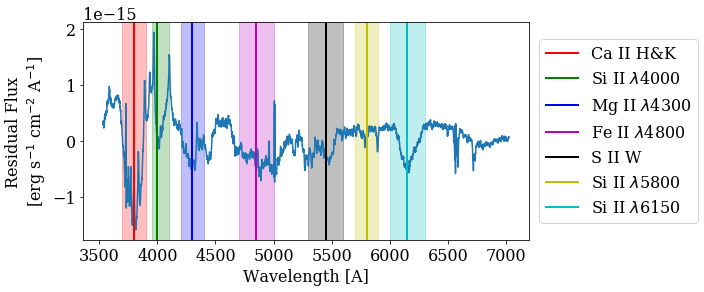

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(global_wavelength_grid, spectrum['RESIDUAL_FLUX'])

colors = 'rgbmkyc'

for i, feature in enumerate(features):
    ax.axvline(features[feature][0], ls='-', lw=2, 
               color=colors[i], label=featurenames[feature])
    ax.axvspan(features[feature][1], features[feature][2],
                alpha=0.25, color=colors[i])
    
ax.set(xlabel='Wavelength [A]', 
       ylabel='Residual Flux\n[erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]')
ax.legend(loc='center', bbox_to_anchor=[1.2,.5])

savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/'
savedir += 'thesis/Figures/'

# plt.savefig(savedir + 'snhost_residual_features.pdf', format='pdf',
#                dpi=300, bbox_inches='tight')

In [15]:
from scipy.optimize import curve_fit

In [16]:
# Define functions to fit, centered at the feature
def gaussian(x, a, c):
    return a * np.exp(-(x - feature_wavecenter)**2 / c)

def poly(x, a, b, c):
    return a + b*(x - feature_wavecenter) + c*(x - feature_wavecenter)**2

In [17]:
def get_amplitude(f, feature, spectrum):
    
    feature_data = features[feature]
    feature_wavecenter, feature_wavemin, feature_wavemax = feature_data

    # Select out the region of the spectra surrounding the feature
    cut = ((global_wavelength_grid > feature_wavemin) &
            (global_wavelength_grid < feature_wavemax))
    
    # Normalize flux to get representative amplitudes
    norm = np.linalg.norm(spectrum['RESIDUAL_FLUX'])
    
    feature_wave = global_wavelength_grid[cut]
    feature_flux = spectrum['RESIDUAL_FLUX'][cut] / norm
    feature_err = 1e-17 / np.sqrt(spectrum['RESAMPLED_IVAR'][cut]) / norm
    
    # Do the fit
    popt, pcov = curve_fit(f, feature_wave, feature_flux, 
                            sigma=feature_err, method='lm'
                          )
        
    fit = f(feature_wave, *popt)
    amplitude = (np.max(fit) - np.min(fit)) / np.mean(feature_err)
        
    return amplitude, fit


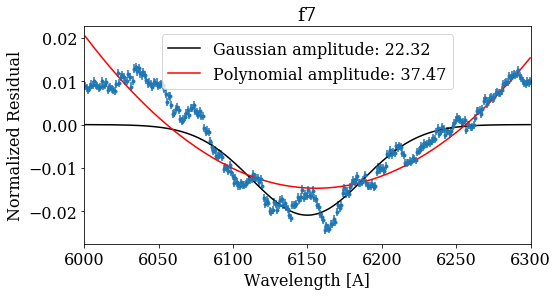

In [18]:
for feature in ['f7']: # sorted(features.keys()):
    feature_data = features[feature]
    feature_wavecenter, feature_wavemin, feature_wavemax = feature_data
    
    # Select out the region of the spectra surrounding the feature
    cut = ((global_wavelength_grid > feature_wavemin) &
            (global_wavelength_grid < feature_wavemax))
    
    # Normalize flux to get representative amplitudes
    norm = np.linalg.norm(spectrum['RESIDUAL_FLUX'])
    
    feature_wave = global_wavelength_grid[cut]
    feature_flux = spectrum['RESIDUAL_FLUX'][cut] / norm
    feature_err = 1e-17 / np.sqrt(spectrum['RESAMPLED_IVAR'][cut]) / norm

    
    poly_amplitude, poly_fit = get_amplitude(poly, feature,
                                                    spectrum)
    
    gaussian_amplitude, gaussian_fit = get_amplitude(gaussian, feature,
                                                    spectrum)

#     print "poly:  %.2f" % poly_amplitude
#     print "gauss: %.2f" % gaussian_amplitude

    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.errorbar(feature_wave, feature_flux, yerr=feature_err, fmt='.')
    ax.plot(feature_wave, gaussian_fit, color='k',
            label='Gaussian amplitude: %.2f' % gaussian_amplitude)
    ax.plot(feature_wave, poly_fit, color='r',
            label='Polynomial amplitude: %.2f' % poly_amplitude)
    ax.set(xlabel='Wavelength [A]', ylabel='Normalized Residual',
          xlim=[feature_wavemin, feature_wavemax],
          title='%s' % feature)
    ax.legend(loc='best')
    
# plt.savefig(savedir + 'snhost_example_residuals_f7.pdf', format='pdf',
#                dpi=300, bbox_inches='tight')

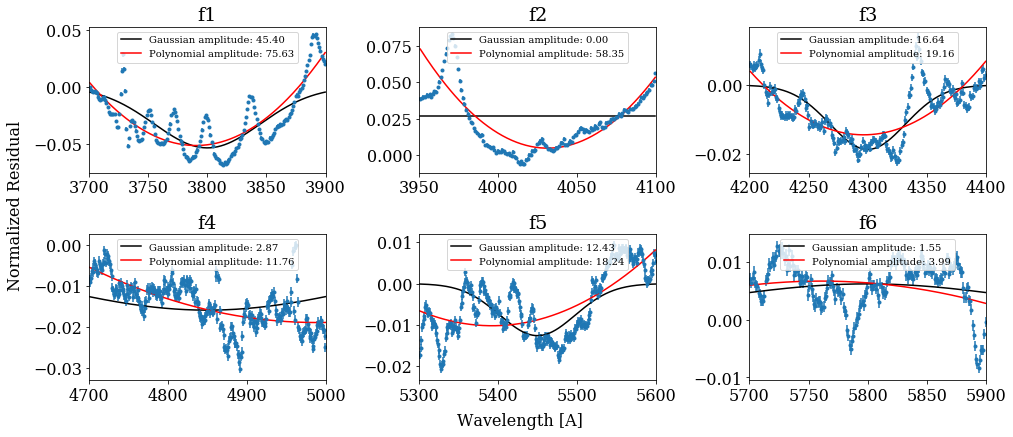

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(14,6))

plotfeatures = sorted(features.keys())
plotfeatures = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
for feature, ax in zip(plotfeatures, axes.flatten()): # ['f7']:
    feature_data = features[feature]
    feature_wavecenter, feature_wavemin, feature_wavemax = feature_data
    
    # Select out the region of the spectra surrounding the feature
    cut = ((global_wavelength_grid > feature_wavemin) &
            (global_wavelength_grid < feature_wavemax))
    
    # Normalize flux to get representative amplitudes
    norm = np.linalg.norm(spectrum['RESIDUAL_FLUX'])
    
    feature_wave = global_wavelength_grid[cut]
    feature_flux = spectrum['RESIDUAL_FLUX'][cut] / norm
    feature_err = 1e-17 / np.sqrt(spectrum['RESAMPLED_IVAR'][cut]) / norm

    poly_amplitude, poly_fit = get_amplitude(poly, feature,
                                                    spectrum)
    
    gaussian_amplitude, gaussian_fit = get_amplitude(gaussian, feature,
                                                    spectrum)
    
    # Plot data for given feature
    ax.errorbar(feature_wave, feature_flux, yerr=feature_err, fmt='.')
    
    # Plot best fits
    ax.plot(feature_wave, gaussian_fit, color='k',
            label='Gaussian amplitude: %.2f' % gaussian_amplitude)
    ax.plot(feature_wave, poly_fit, color='r',
            label='Polynomial amplitude: %.2f' % poly_amplitude)
    
    ax.set(xlim=[feature_wavemin, feature_wavemax],
           title='%s' % feature)
    ax.legend(loc='upper center', fontsize=10)
    
fig.text(0.5, 0, 'Wavelength [A]', ha='center', va='center')
fig.text(0, 0.5, 'Normalized Residual',
                ha='center', va='center', rotation='vertical')
# axes[-1,-1].remove()
fig.tight_layout()

# plt.savefig(savedir + 'snhost_example_residuals_no-f7.pdf', format='pdf',
#                dpi=300, bbox_inches='tight')

In [20]:
feature_poly_amplitudes = []
feature_gaussian_amplitudes = []
fitfailed = 0

for spectrum in spec_table:
    poly_amplitudes = []
    gaussian_amplitudes = []
    for feature in sorted(features.keys()):
        feature_data = features[feature]
        feature_wavecenter, feature_wavemin, feature_wavemax = feature_data

        poly_amplitude, poly_fit = get_amplitude(poly, 
                                                 feature,
                                                 spectrum)

        try:
            gaussian_amplitude, gaussian_fit = get_amplitude(gaussian, 
                                                         feature,
                                                         spectrum)
        except:
            gaussian_amplitude = 0
            fitfailed += 1
            
        poly_amplitudes.append(poly_amplitude)
        gaussian_amplitudes.append(gaussian_amplitude)

    feature_poly_amplitudes.append(poly_amplitudes)
    feature_gaussian_amplitudes.append(gaussian_amplitudes)
    
spec_table['POLY_FEATURES'] = feature_poly_amplitudes
spec_table['GAUSSIAN_FEATURES'] = feature_gaussian_amplitudes


/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:457: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


In [21]:
print fitfailed

1


In [22]:
# spec_table[0]['FEATURES']
print spec_table[0]['POLY_FEATURES']
print spec_table[0]['GAUSSIAN_FEATURES']

[ 75.6312151   58.34649036  19.16098849  11.75788426  18.23834012
   3.98657727  37.47109838]
[  4.53971571e+01   4.88523544e-06   1.66442819e+01   2.87168812e+00
   1.24295629e+01   1.54754452e+00   2.23215682e+01]


## Run random forest classifier on featureset

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [39]:
# Load feature values into one overall table
# each column = one feature
table  = []
names  = []
dtypes = []

num_features = len(features)

for spec in spec_table:
#     tablerow = np.append(spec['POLY_FEATURES'], spec['HAS_SN'])
    tablerow = np.append(spec['GAUSSIAN_FEATURES'], spec['HAS_SN'])
    table.append(tablerow)

for i in range(1,num_features+1):
    names.append("f%d" % i)
    dtypes.append(np.float32)
    
names.append('HAS_SN')
dtypes.append('S')

data = Table(rows=table, names=names, dtype=dtypes)

In [40]:
df = data.to_pandas()

In [41]:
df[:5]

,f1,f2,f3,f4,f5,f6,f7,HAS_SN
0,45.397156,0.000005,16.644281,2.871688,12.429563,1.547544,22.321568,Ia
1,0.667821,0.848933,0.449839,0.273789,0.717181,0.284225,0.755979,False
2,42.732471,0.000004,17.496225,2.884403,14.472230,1.889724,27.455656,Ia
3,0.640924,0.614507,1.079663,0.429587,0.414153,0.424112,1.199557,False
4,1.552222,0.792079,1.245729,0.030199,0.838450,1.367796,0.931455,False


In [42]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

In [43]:
# We now split the dataframes into a test and training dataset
train, test = df[df['is_train']==True], df[df['is_train']==False]
print 'Number of observations in the training data:', len(train)
print 'Number of observations in the test data:',len(test)

Number of observations in the training data: 28412
Number of observations in the test data: 9388


In [44]:
train_count = Counter(train['HAS_SN'])
test_count  = Counter(test['HAS_SN'])

trainstr = ""
for k in train_count.keys():
    trainstr += "%s %d," % (k, train_count[k])
print "Training set: %d: (%s)" % (len(train), trainstr)
    
teststr = ""
for k in test_count.keys():
    teststr += "%s %d," % (k, test_count[k])
print "Training set: %d: (%s)" % (len(test), teststr)

Training set: 28412: (Ia 14250,False 14162,)
Training set: 9388: (Ia 4650,False 4738,)


In [45]:
features = df.columns[:-2]
features

Index([u'f1', u'f2', u'f3', u'f4', u'f5', u'f6', u'f7'], dtype='object')

In [46]:
# train['species'] has the "true" species names
# in order to compare later it needs to be coded into integers (0, 1, 2)

y, objtypes = pd.factorize(train['HAS_SN'])

# Now we train the random forest
clf = RandomForestClassifier(n_jobs=1, 
                             random_state=0,
                             verbose=0)

clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [47]:
# Apply the classifier to the test data
clf.predict(test[features])

array([1, 0, 1, ..., 0, 0, 0])

In [48]:
# Convert back to english
preds = [objtypes[i] for i in clf.predict(test[features])]

In [49]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(test['HAS_SN'].tolist(), preds)
cm.print_stats()

population: 9388
P: 4650
N: 4738
PositiveTest: 4648
NegativeTest: 4740
TP: 4647
TN: 4737
FP: 1
FN: 3
TPR: 0.99935483871
TNR: 0.999788940481
PPV: 0.999784853701
NPV: 0.999367088608
FPR: 0.000211059518784
FDR: 0.000215146299484
FNR: 0.000645161290323
ACC: 0.999573924159
F1_score: 0.999569799957
MCC: 0.999147860741
informedness: 0.999143779191
markedness: 0.999151942308
prevalence: 0.495313165744
LRP: 4734.94322581
LRN: 0.0006452974865
DOR: 7337613.0
FOR: 0.000632911392405


In [50]:
# Display how well the classifier did via a confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['HAS_SN'], preds, labels=objtypes)
print objtypes
print cm

Index([u'False', u'Ia'], dtype='object')
[[4737    1]
 [   3 4647]]


In [51]:
correct = 0
incorrect = 0
for true, pred in zip(test['HAS_SN'], preds):
    if true == pred:
        correct += 1
#         print true, pred
    else:
        incorrect+= 1
#         print true, pred
        
print correct, incorrect

9384 4


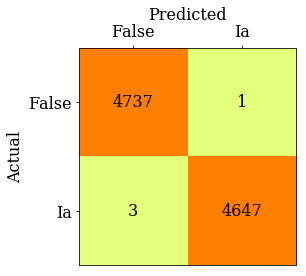

In [52]:
norm_cm = []
for i in cm:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_cm.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_cm), cmap='Wistia',
                interpolation='nearest')

width, height = cm.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    color='k',
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(range(width), objtypes[:width])
plt.yticks(range(height), objtypes[:height])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig('../plots/confusion_matrix.png', format='png', 
#             dpi=300, bbox_inches='tight')

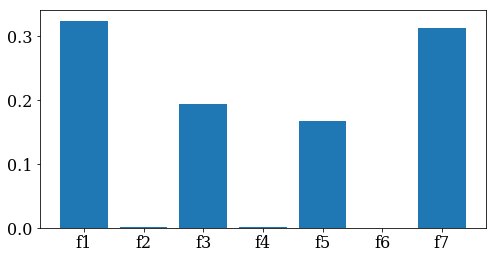

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.bar(range(len(features)), clf.feature_importances_)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features)
print